In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from PIL import Image


path = "ROIs1158_spring/s2_24/ROIs1158_spring_s2_24_p30.tif"

Normalized array data: [[[1.    1.    1.   ]
  [1.    1.    1.   ]
  [1.    1.    1.   ]
  ...
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]]

 [[1.    1.    1.   ]
  [1.    1.    1.   ]
  [1.    1.    1.   ]
  ...
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]]

 [[1.    1.    1.   ]
  [1.    1.    1.   ]
  [1.    1.    1.   ]
  ...
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]]

 ...

 [[0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  ...
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]]

 [[0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  ...
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]]

 [[0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  ...
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]
  [0.875 1.    1.   ]]]


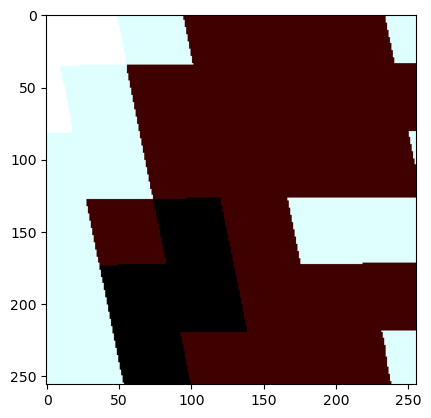

In [4]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# bands 1, 2, 3 = R G B
path = "C:/Users/Paddy/CRT/Github/input/SEN12MS/ROIs1158_spring/s2_1/ROIs1158_spring_s2_1_p30.tif"
path1 = "C:/Users/Paddy/CRT/Github/met/generated_images/tif_example.tif"
path = "C:/Users/Paddy/CRT/Github/input/sen12_lc.tif"

src = rasterio.open(path)


# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
blue = src.read(4).astype(np.int32)
green = src.read(3).astype(np.int32)
red = src.read(2).astype(np.int32)

# Normalize band DN
nir_norm = normalize(blue)
red_norm = normalize(red)
green_norm = normalize(green)

# Stack bands
nrg = np.dstack((red_norm, nir_norm, green_norm))
print("Normalized array data:", nrg)

# View the color composite
plt.imshow(nrg)

max:9, min:4, mean:5.8259124755859375
max:22, min:14, mean:17.309417724609375
max:20, min:10, mean:13.039703369140625
max:20, min:10, mean:13.039703369140625


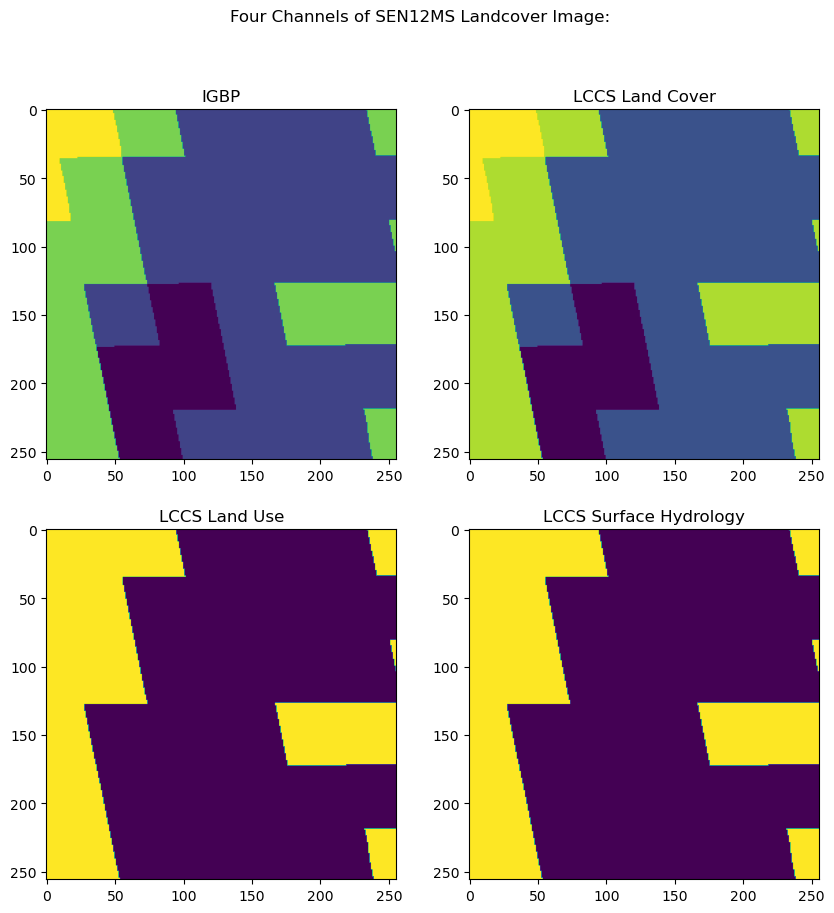

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

path = "C:/Users/Paddy/CRT/Github/input/sen12_lc.tif"

lc = rasterio.open(path)

fig, axs = plt.subplots(2,2, figsize=(10,10))
fig_titles = ["IGBP", "LCCS Land Cover", "LCCS Land Use", "LCCS Surface Hydrology"]
fig.suptitle("Four Channels of SEN12MS Landcover Image:")

for i, ax in enumerate(axs.flatten()):
    band = pd.DataFrame(lc.read(i+1).astype(np.int32))
    print(f"max:{np.max(band)}, min:{np.min(band)}, mean:{np.mean(band)}")
    ax.set_title(fig_titles[i])
    ax.imshow(band)

plt.show()